# Protein-Based Machine Learning Model for Tumor Detection

## Overview:

The project aims to develop a machine learning model for tumor detection using protein data obtained from biopsy samples.
The primary objective is to create a model that can accurately classify samples as tumor or non-tumor based on protein profiles.
The focus is on leveraging machine learning techniques to analyze protein data and improve tumor detection accuracy.
The project aims to verify the effectiveness of the model by evaluating its performance against existing diagnostic methods.

### Project Steps:

- Data Collection

- Data Preprocessing

- Model Development

- Model Evaluation

- Conclusion

## Data Collection

The data used for this project is provided by Kaggle - see [dataset](https://www.kaggle.com/datasets/jillanisofttech/brain-tumor).


## Data Preprocessing

The data I am using is fairly clean but we will still need to assess the data, clean it, and split for our training, validating and testing data. 

In [2]:
import pandas as pd

# Read the file
data = pd.read_csv('data\\brain_tumor_data.csv')

### Assess the data

In [3]:
print(data.head())

   Unnamed: 0  X53416  M83670  X90908  M97496  X90908.1  U37019  R48602  \
0           0      70     -81      25      10        22     113      36   
1           1     108     -30      -7      60         0      24       8   
2           2      75      -1       5      48         6      34      27   
3           3     871       4      14      78        -6      85      65   
4           4     -92     -34      14      19        11      -6      27   

   T96548  X64559  ...  H87456  R64130  H11125.1  U22055  L22524  M13699.1  \
0     163       9  ...      75       5        68     138      53        -4   
1     113      -3  ...     186       6        60      93     140        -3   
2      35      -1  ...     186     225        94      62      39       -14   
3     227      19  ...      77       6        78      30      87        -4   
4      -8       9  ...      87     303       204      81     105         9   

   X54489  T55008  M10065.2      y  
0     123       2        19  tumor  
1     

We can see the data consist of columns of proteins and the final column being our target which we will try to predict.

In [4]:
print(data.shape)  # Get the dimensions of the data (rows, columns)
print(data.describe())  # Display information about the data, including column data types and missing values

(36, 7466)
       Unnamed: 0       X53416      M83670       X90908       M97496  \
count   36.000000    36.000000   36.000000    36.000000    36.000000   
mean    17.500000   378.750000  177.305556   128.027778   568.305556   
std     10.535654   648.716067  243.494655   787.935802   637.451928   
min      0.000000  -694.000000 -117.000000   -50.000000     8.000000   
25%      8.750000   -95.750000  -31.000000   -13.250000    47.250000   
50%     17.500000   194.500000  117.000000    -4.500000   293.500000   
75%     26.250000   721.750000  330.500000    14.000000  1079.250000   
max     35.000000  1815.000000  718.000000  4723.000000  2261.000000   

          X90908.1       U37019      R48602       T96548      X64559  ...  \
count    36.000000    36.000000   36.000000    36.000000   36.000000  ...   
mean     93.555556   366.833333  140.166667   644.194444   73.444444  ...   
std     557.527370   427.166645  171.443202   685.514231   88.504219  ...   
min     -54.000000    -6.000000 

Here we can see that there is only 36 samples which is rather low and may cause some issues when validating and testing.

We can also see that the we have many feature columns.

#### Cleaning

I want to remove the number column and check what our target can be.

In [5]:
clean_data = data.drop('Unnamed: 0', axis=1)
# Check what y can be
print(clean_data['y'].unique())

['tumor' 'Normal']


We want to map our y to 0 or 1 for Normal and tumor respectively so it is easier to work with.

In [6]:
clean_data['y'].replace(['tumor', 'Normal'], [1, 0], inplace=True)

As our dataset is so small I will use 'Leave-One-Out Cross-Validation' as it will give a less biased performance estimate which will hopefully be at less risk of chance. As such I will leave the data splitting for later.

I now want to seperate the features and the target.

In [7]:
X = clean_data.drop('y', axis=1)
y = clean_data['y']

## Model Development

I am going to try 3 different models and assess their comparative performance, these models are:

- Support Vector Machines
- Random Forest
- Neural Networks

These have been selected as they are effective for the type of data we are using which has small but has many features.

### Leave-One-Out Cross-Validation (LOOCV)

I am going to start by creating function to perform our LOOCV which can be applied to each model.

In [8]:
from sklearn.model_selection import LeaveOneOut

# Create the cross-validator
loo = LeaveOneOut()

# Testing function
def model_tester(X, y, model):
    # Initialize lists to store predictions and true value
    predictions = []
    true_values = []

    # LOOCV
    for train_index, val_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model on the training set
        model.fit(X_train, y_train)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val)
        
        # Append predictions and true labels to the lists
        predictions.append(y_pred[0])
        true_values.append(y_val.values[0])
    
    bad_predict = []
    for i, pred in enumerate(predictions):
        if pred != true_values[i]:
            bad_predict.append(i)
            
    print(bad_predict)
            
            
    # Calculate accuracy - 1 perfect, 0 awful
    return sum(1 for pred, true in zip(predictions, true_values) if pred == true) / len(true_values)

### Support Vector Machines

Support Vector Machines (SVM) is a machine learning algorithm that seeks to find an optimal hyperplane in a high-dimensional space to separate data points into different classes, maximizing the margin between the classes and leveraging kernel functions to handle non-linear relationships.

I will start with the basic model provided by scikit-learn and see how the default hyperparameters perform.

In [9]:
from sklearn.svm import SVC

# Create an SVM classifier
svm_model = SVC()

# Train and test the model using the function from before
svm_accuracy = model_tester(X, y, svm_model)

print(svm_accuracy)

[23]
0.9722222222222222


An accuracy of 97% is pretty good but I will experiment with the hyperparameters to see if we can get 100%.

Let's start with the kernel:

In [10]:
kernel_list = ['linear', 'poly', 'sigmoid']

for kernel_type in kernel_list:
    svm_model = SVC(kernel=kernel_type)
    svm_accuracy = model_tester(X, y, svm_model)
    print(f'Kernel: {kernel_type}\nAccuracy: {svm_accuracy}\n')

[23]
Kernel: linear
Accuracy: 0.9722222222222222

[23]
Kernel: poly
Accuracy: 0.9722222222222222

[23]
Kernel: sigmoid
Accuracy: 0.9722222222222222



Interestingly they all achieve the same accuracy which might suggest any of the options are at the limit of what the model can predict and that the defaults from sci-kit learn are very effective.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[23]
[23]
[23, 26]
[23, 25, 26, 34]
[23, 25, 26, 34]
[23, 25, 26, 34]
[23, 24, 25, 26, 29, 31, 33, 34]
[23, 24, 25, 26, 29, 31, 32, 33, 34]
[23, 24, 25, 26, 29, 31, 32, 33, 34]


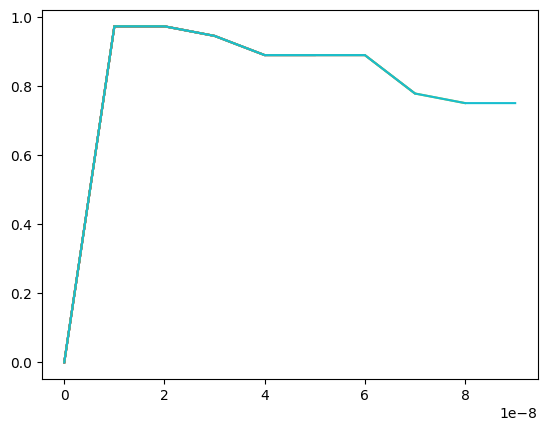

0.9722222222222222


In [11]:
# Gamma
import matplotlib.pyplot as plt

# gamma_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2]
# gamma_list = [0.0000000001]
gamma_list = [x/100000000000 for x in range(1, 10001, 1000)]
accuracy = []
i = 1

for gamma_val in gamma_list:
    svm_model = SVC(gamma=gamma_val)
    accuracy.append(model_tester(X, y, svm_model))
    plt.plot(gamma_list[:i], accuracy)
    i += 1

plt.show()
print(max(accuracy))

We can see that there is a clear clear peak in accuracy and as gamma continues to increase the accuracy drops off.

By default gamma is 'scale' which uses 1 / (n_features * X.var()) as value of gamma which appears to be very effective and is the max I found in testing.

Let's move onto Random Forest

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_accuracy = model_tester(X, y, rf_model)
print(rf_accuracy)

[23]
0.9722222222222222


Let's see if we can get the final prediction.

### n_estimators

We'll start with n_estimators.

[23]
[23]
[23]
[23]
[23]
[23]
[23]
[23]
[23]


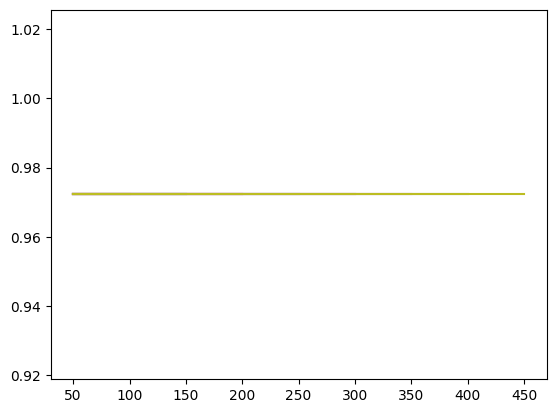

0.9722222222222222


In [13]:
n_est_list = [x for x in range(50, 500, 50)]
accuracy = []
i = 1

for n_est in n_est_list:
    rf_model = RandomForestClassifier(n_estimators=n_est)
    accuracy.append(model_tester(X, y, rf_model))
    plt.plot(n_est_list[:i], accuracy)
    i += 1

plt.show()
print(max(accuracy))

It seems to make no measurable difference so let's try 'max_depth' and the larger number of estimators are taking a large amount of time (1 minutes to 10 minutes).

### max_depth

A reasonable range for this is between 3 and 100 but in our case with a small dataset so we will keep to less than 20.

[23]
[23]
[23]
[23]
[23]
[23]


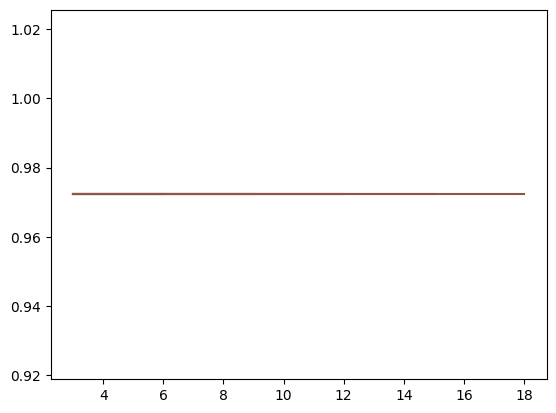

0.9722222222222222


In [14]:
depth_list = [x for x in range(3, 20, 3)]
accuracy = []
i = 1

for depth in depth_list:
    rf_model = RandomForestClassifier(max_depth=depth, random_state=8)
    accuracy.append(model_tester(X, y, rf_model))
    plt.plot(depth_list[:i], accuracy)
    i += 1

plt.show()
print(max(accuracy))

This appears to have no affect on the accuracy of the model.

I think we can move on to Neural Networks.

## Neural Networks

For a NN we need to standardise the training data, I am going to use a StandardScaler in scikit-learn.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now we can go ahead a make the model. We are going to use dense layers so they are fully connected and the Adam optimiser as it's a great all round choice. We are also going to use the 'binary_crossentropy' loss function as it is good for binary classification and works with the signmoid activation layer.

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy


tf.random.set_seed(42)

nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_dim=X_scaled.shape[1]))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Accuracy()])

And now test the accuracy of the model with the initial hyperparameters.

Unfortunately the function I was using before for training and testing won't work as we need to specify some of the hyperparameter in the fit function. We will focus on 2 hyper parameters: epochs and batch_size.

In [36]:
def model_tester_nn(X, y, model, epochs, batch_size):
    
    # Initialize lists to store predictions and true value
    accuracies = []
    
    loo = LeaveOneOut()

    # LOOCV
    for train_index, val_index in loo.split(X):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model on the training set
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Make predictions on the validation set
        _, accuracy = model.evaluate(X_val, y_val)
        
        # Append predictions and true labels to the lists
        accuracies.append(accuracy)
            
            
    # Calculate accuracy - 1 perfect, 0 awful
    return sum(accuracies) / len(accuracies)

Now test.

In [37]:
print(model_tester_nn(X_scaled, y, nn_model, 10, 32))

1/1 [==============================] - 0s 26ms/step - loss: 2.1470e-08 - accuracy: 0.0000e+00
0.25


Now let's try vary the hyper parameters starting with epochs which for a dataset of this size should roughly be between 10 and 50.

1/1 [==============================] - 0s 27ms/step - loss: 1.4220e-11 - accuracy: 0.0000e+00


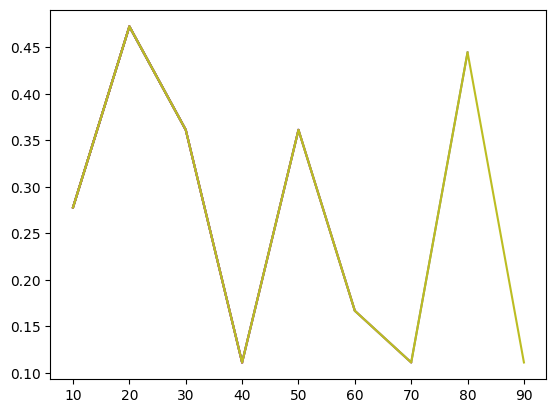

0.4722222222222222


In [39]:
epoch_list = [x for x in range(10, 100, 10)]

accuracy = []
i = 1



for epochs in epoch_list:
    nn_model = Sequential()
    nn_model.add(Dense(64, activation='relu', input_dim=X_scaled.shape[1]))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dense(1, activation='sigmoid'))
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Accuracy()])
    accuracy.append(model_tester_nn(X, y, nn_model, epochs, 32))
    plt.plot(epoch_list[:i], accuracy)
    i += 1

plt.show()
print(max(accuracy))

The change in accuracy appears to be very random which is not a good sign for the model which suggests any correct predictions are more random than accurate.

I'm going to try change the batch size to see if this can give any more consistent results.

1/1 [==============================] - 0s 21ms/step - loss: 9.5161e-08 - accuracy: 0.0000e+00


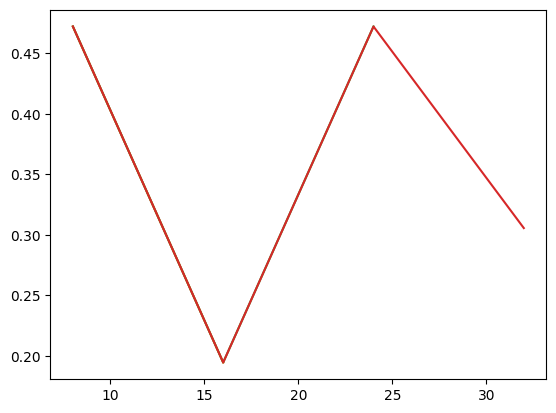

0.4722222222222222


In [40]:
batch_list = [x for x in range(8, 40, 8)]

accuracy = []
i = 1



for batch in batch_list:
    nn_model = Sequential()
    nn_model.add(Dense(64, activation='relu', input_dim=X_scaled.shape[1]))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dense(1, activation='sigmoid'))
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[Accuracy()])
    accuracy.append(model_tester_nn(X, y, nn_model, 20, batch))
    plt.plot(batch_list[:i], accuracy)
    i += 1

plt.show()
print(max(accuracy))

Again, we can see no clear pattern and a seemingly random outcome from this range of batch sizes.

I will not try varying the optimiser learning rate to see if we can gain any accuracy.

1/1 [==============================] - 0s 22ms/step - loss: 9.9645e-13 - accuracy: 0.0000e+00


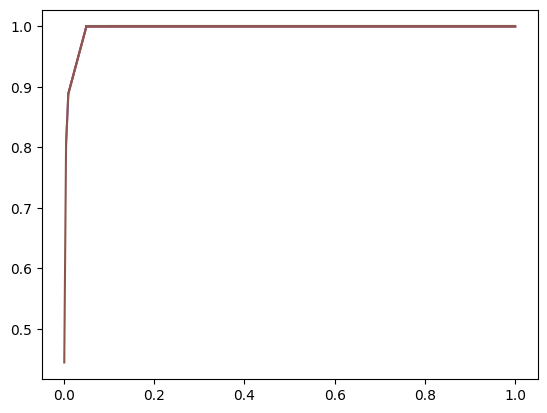

1.0


In [42]:
learning_list = [1, 0.1, 0.05, 0.01, 0.005, 0.001]

accuracy = []
i = 1



for learn_rate in learning_list:
    nn_model = Sequential()
    nn_model.add(Dense(64, activation='relu', input_dim=X_scaled.shape[1]))
    nn_model.add(Dense(32, activation='relu'))
    nn_model.add(Dense(1, activation='sigmoid'))
    nn_model.compile(optimizer=Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=[Accuracy()])
    accuracy.append(model_tester_nn(X, y, nn_model, 20, 8))
    plt.plot(learning_list[:i], accuracy)
    i += 1

plt.show()
print(max(accuracy))

Finally, the learning rate has made a huge difference in the accuracy and achieved 100% accuracy.

It's likely the learning rate was too slow for this small data set so was unable to converge although which may explain the seemingly random accuracy of the previous experimentation.

## Conclusion

Both the Support Vector Machines and Random Forest models gave very accurate consistent predictions with minimal adjustment to hyper parameters which suggests they are a good model for this problem. However, Neural Networks ultimately achieved the highest accuracy but required siginificantly more tuning.

Ultimately, this dataset is rather small and doesn't allow the full testing of the models. It would be very interesting to see the performance of these models on a larger dataset.